# 04. Pytorch Custom Datasets

Depending on what you're working on, PyTorch's domain libraries house existing data loading functions and customizable data loading functions.

Domain Libraries:
- torchvision
- torchtext
- torchaudio
- etc...

## 0. Importing PyTorch and Setting up Device-Agnostic Code

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
!nvidia-smi

Wed Jan 31 01:20:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of the Food101 dataset, which has 101 different food classes and 1000 images per class. Our dataset starts with 3 classes of food and only 10% of the images.

We only select a portion of the data to create our model on a small scale, in order to speed up our experiement.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists, skipping download.")
else:
  print(f"{image_path} does not exist, creating directory.")
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"{image_path} directory created.")

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/0fa794be523a10b409a2061e43ae03c419d5ace7/data/pizza_steak_sushi.zip")
  print("Downloading data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating directory.
data/pizza_steak_sushi directory created.
Unzipping pizza, steak, and sushi data...


## 2. Data Preparation & Exploration

In [5]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames, in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Random Image Path: data/pizza_steak_sushi/train/pizza/1633289.jpg
Random Image Class: pizza
Height: 384 | Width: 512


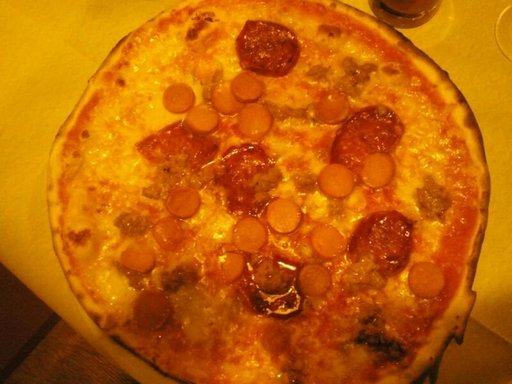

In [8]:
import random
from PIL import Image

# random.seed(14)

# Get all the image paths
image_path_list  = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path and plot it
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Random Image Class: {image_class}")
print(f"Height: {img.height} | Width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

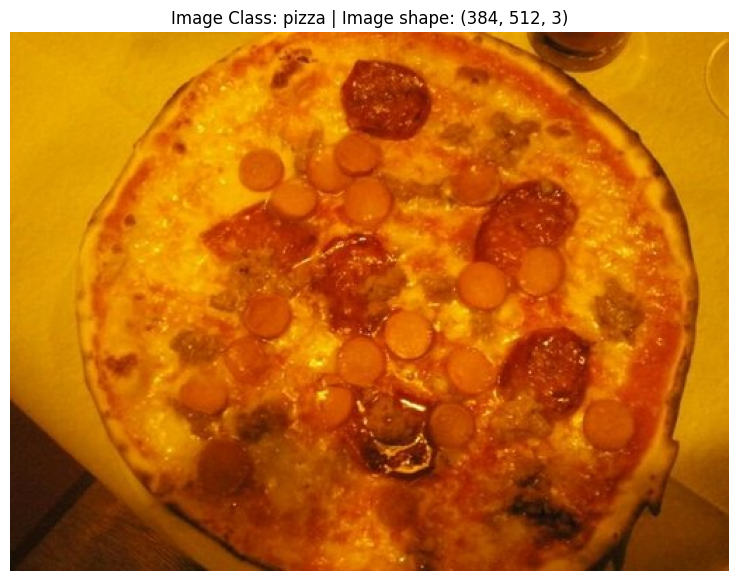

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

In [10]:
img_as_array

array([[[217, 152,   0],
        [218, 153,   0],
        [220, 153,   0],
        ...,
        [208, 138,   6],
        [205, 135,   5],
        [201, 131,   1]],

       [[223, 158,   4],
        [223, 158,   4],
        [225, 158,   5],
        ...,
        [204, 134,   2],
        [203, 133,   3],
        [202, 132,   2]],

       [[222, 157,   1],
        [223, 158,   2],
        [225, 159,   3],
        ...,
        [205, 135,   1],
        [205, 135,   3],
        [205, 135,   3]],

       ...,

       [[ 23,  15,   4],
        [ 25,  15,   3],
        [ 29,  17,   5],
        ...,
        [125,  58,   5],
        [131,  64,  11],
        [135,  68,  13]],

       [[ 25,  15,   3],
        [ 24,  14,   2],
        [ 28,  16,   4],
        ...,
        [134,  65,  10],
        [136,  67,  12],
        [138,  69,  12]],

       [[ 26,  16,   4],
        [ 25,  15,   3],
        [ 29,  15,   2],
        ...,
        [136,  67,  12],
        [137,  66,  10],
        [136,  65,   9]]

## 3. Transforming data into `torch.Tensor` -> `torch.utils.data.Dataset` -> `torch.utils.data.DataLoader`

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

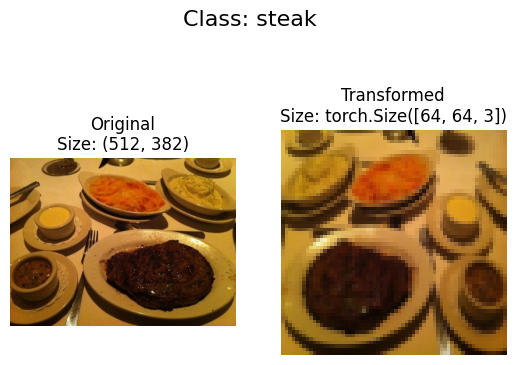

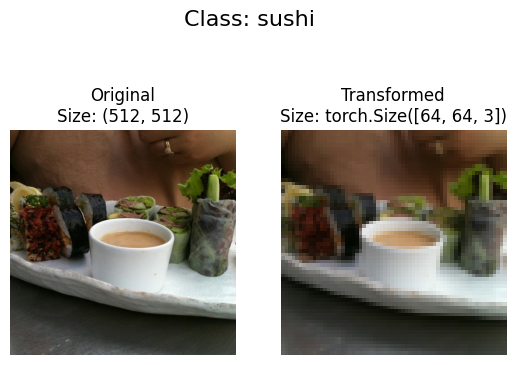

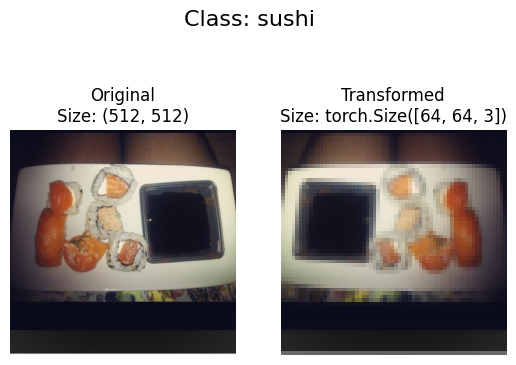

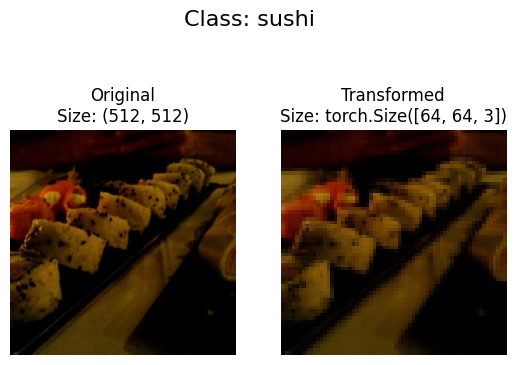

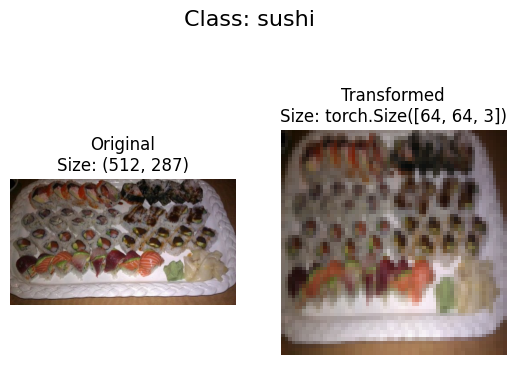

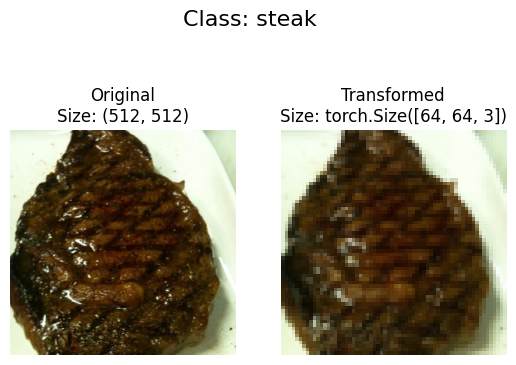

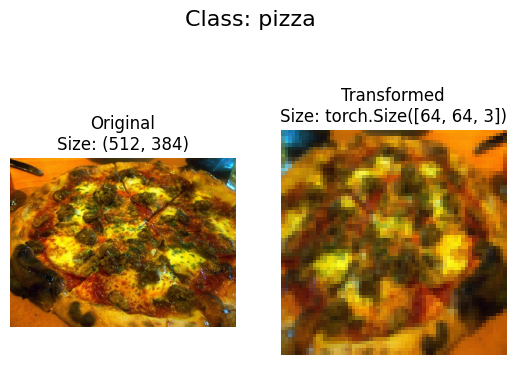

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.size()}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=7)

## 4. Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for data
                                  target_transform=None) # transform for target (labels)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# class_names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data), len(test_data)

(225, 75)

In [20]:
img, label = train_data[0][0], train_data[0][1]

torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

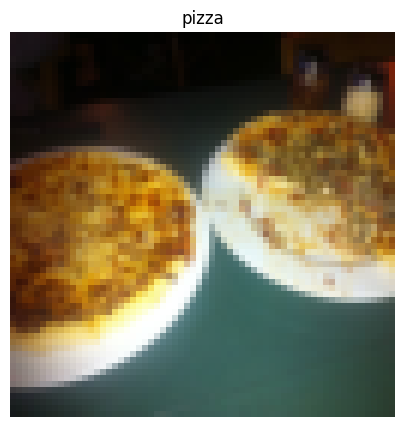

In [21]:
# Plot with plt
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
print(img.shape)
print(img_permute.shape)
plt.figure(figsize=(5,5))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label])

### 4.1 Turn loaded images into dataloaders

dataloaders turn datasets into interables, with customizable batch size

In [22]:
# Turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dddd10505e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dddd10501f0>)

In [23]:
img, label = next(iter(train_dataloader))

# Note: BATCH_SIZE = 1
print(img.shape)
print(label.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [24]:
import os # for dealing with directories
import pathlib # for dealing with file paths
import torch

from PIL import Image # for loading images
from torch.utils.data import Dataset # to subclass and create our own custom Dataset
from torchvision import transforms # to turn images into tensors
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datatsets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""

  # Get class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  # Create a dictionary of index labels, for the model
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

To do:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize subclass with `targ_dir` and `transform` parameters.
3. Create attributes for `paths`, `transform`, `classes`, and `class_to_idx`.
4. Create a function to load images and return them for input/output of vision data.
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`.

In [29]:
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # Initialize with targ_dir (target data dictionary) and transform parameters
  def __init__(self, targ_dir: str, transform=None) -> None:

    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # Make function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # Overwrite __getitem__()
  def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [30]:
# Creating functions to transform images:

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [31]:
# turn train & test images into Datasets using ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7dddd0b9e980>,
 <__main__.ImageFolderCustom at 0x7dddd0b9f1c0>)

In [32]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [33]:
train_data_custom.class_to_idx, test_data_custom.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print(len(train_data_custom) == len(train_data) and len(test_data_custom) == len(test_data))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

Our helper function `display_random_images()` will...
- Take in a `Dataset` and a number of other parameters such as `classes`, the number of images `n`, and a random seed.
- Get a list of random sample indexes (using `random.sample()`).
- Plot the images using `matplotlib`.

In [35]:
# Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # Set random seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

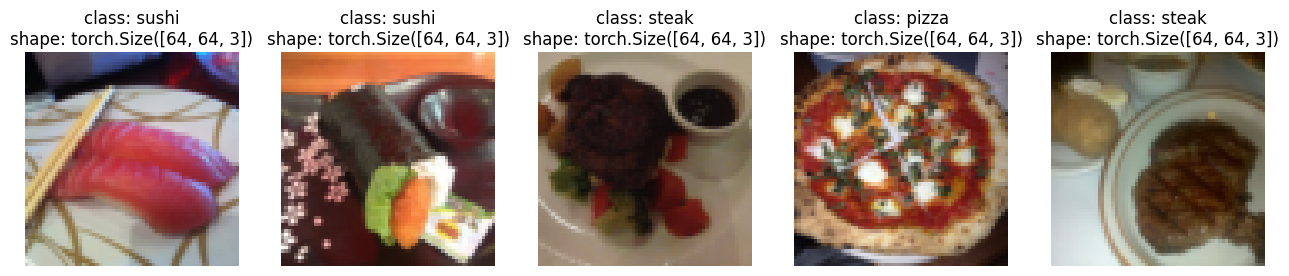

In [36]:
# Display random images from ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


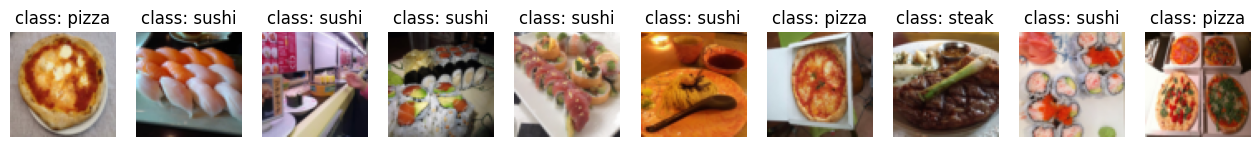

In [37]:
# Display random images from ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`s

In [38]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7dddd0bf2d10>,
 <torch.utils.data.dataloader.DataLoader at 0x7dddd0c50490>)

In [39]:
# Get image and label from custom DataLoader just to compare
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 06. Use other transforms from `torchvision.transforms` to augment data

data augmentation alters the data in some way to artificially increase the diversity of the train dataset, thereby resulting in a model that is capable of better generalization.

In [40]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense the transforms will be (31 is the max)
    transforms.ToTensor() # scales values from 0.0-1.0
])

# Data augmentation is usually only performed on the train data, not the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

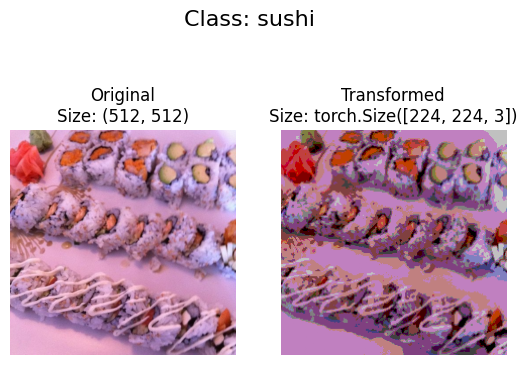

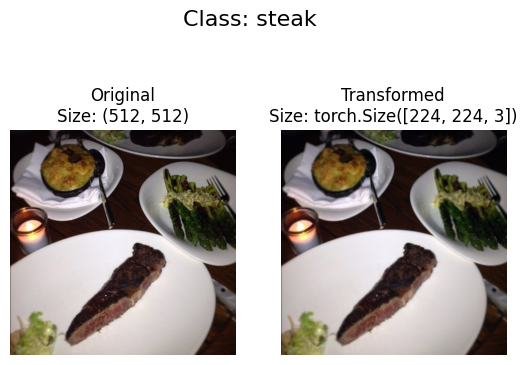

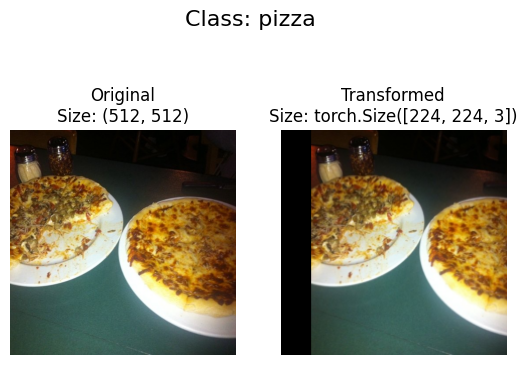

In [41]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [42]:
## 7. Model 0: TinyVGG without data augmentation

In [43]:
# Create simple transform (only resizes images)
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [44]:
# Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Set up contsts
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoaders
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoaders with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7dddd018b7c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dddd0bf3370>)

### 7.2 Create TinyVGG model class

In [50]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape=int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, # comes from trial and error
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [51]:
# instatiate model
torch.manual_seed(14)
model_0 = TinyVGG(input_shape=3, # Number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [53]:
# Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output Logits:\n{pred}\n")
print(f"Output Pred Probs:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output Pred Label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}\n")

Single image shape: torch.Size([1, 3, 64, 64])

Output Logits:
tensor([[-0.0371,  0.0348,  0.0234]], device='cuda:0')

Output Pred Probs:
tensor([[0.3188, 0.3426, 0.3387]], device='cuda:0')

Output Pred Label:
tensor([1], device='cuda:0')

Actual label:
0



### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [54]:
# Install torchinfo if it's not available, and import
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loop functions

In [ ]:
# this function represents a train step, taking in a model, DataLoader, loss fn, optimizer, and performing training steps.
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoaders,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
